In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import math
import random

seed = 42

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### Loading Data

In [4]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

mnist_raw = loadmat("data/mnist-original.mat")
X = mnist_raw["data"].T.astype(int)
y = mnist_raw["label"].ravel().astype(int)

X, X_test, y, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=seed
)

### Data Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_pca(
    X: np.ndarray,
    X_test: np.ndarray,
    n_components: list[int]
) -> dict[int, tuple[np.ndarray, np.ndarray]]:
    """
    X shape: (n_samples, 784)
    returns: { n_components: (n_samples, n_components)... }
    """
    # fit PCA up to largest
    max_k = max(n_components)
    pca = PCA(random_state=seed, n_components=max_k).fit(X)
    X_pca      = pca.transform(X)
    X_test_pca  = pca.transform(X_test)

    # grab top n components for each n
    return { n: (X_pca[:, :n], X_test_pca[:, :n]) for n in n_components }

def preprocess_raw(
    X: np.ndarray,
    X_test: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    X shape: (n_samples, 784)
    returns: (n_samples, 784)
    """
    scaler = StandardScaler().fit(X)
    return scaler.transform(X), scaler.transform(X_test)

def preprocess_conv(
    X: np.ndarray,
    X_test: np.ndarray,
    filters: list[int] = [16, 32, 64],
    kernel_size: tuple[int, int] = (3, 3),
    pool_size: tuple[int, int] = (2, 2),
    latent_dim: int = 128,
    activation: str = "relu",
    padding: str = "same",
    epochs: int = 20,
    batch_size: int = 256
) -> tuple[np.ndarray, np.ndarray]:
    """
    X shape: (n_samples, 784)
    returns: (n_samples, latent_dim)
    """
    # reshape, normalize
    n_train, _ = X.shape
    X_img = (X.astype("float32") / 255.0).reshape(n_train,28,28,1)
    n_test, _ = X_test.shape
    X_test_img = (X_test.astype("float32") / 255.0).reshape(n_test,28,28,1)
    y_cat = tf.keras.utils.to_categorical(y, 10)

    # build encoder
    inp = tf.keras.Input((28,28,1))
    x   = inp
    # conv + pool blocks
    for ch in filters:
        x = tf.keras.layers.Conv2D(
                ch, 
                kernel_size, 
                activation=activation,
                padding=padding
            )(x)
        x = tf.keras.layers.MaxPooling2D(pool_size)(x)
    # global pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(latent_dim, activation="relu")(x)
    # final classification head
    out = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs=inp, outputs=out, name="cnn_classifier")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_img, y_cat, epochs=epochs, batch_size=batch_size, verbose=0)

    # grab bottleneck out as encoder
    encoder_output = model.layers[-2].output
    encoder = tf.keras.Model(inputs=inp, outputs=encoder_output, name="cnn_encoder")

    # extract features
    return encoder.predict(X_img, verbose=0), encoder.predict(X_test_img, verbose=0)


def preprocess_fixed_conv(
    X: np.ndarray,
    X_test: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    X shape: (n_samples, 784)
    returns: (n_samples, 150)
    """
    # reshape, normalize
    n_train, _ = X.shape
    X_img = (X.astype("float32") / 255.0).reshape(n_train,28,28,1)
    n_test, _ = X_test.shape
    X_test_img = (X_test.astype("float32") / 255.0).reshape(n_test,28,28,1)

    # build 6 3x3 filters for feature detection
    sobel_x = np.array([
        [1,0,-1],
        [2,0,-2],
        [1,0,-1]], dtype="float32")
    sobel_y = sobel_x.T
    prewitt_d1 = np.array([
        [1,1,0],
        [1,0,-1],
        [0,-1,-1]], dtype="float32")
    prewitt_d2 = prewitt_d1.T
    laplacian = np.array([
        [0,1,0],
        [1,-4,1],
        [0,1,0]], dtype="float32")
    gauss3 = np.array([
        [1,2,1],
        [2,4,2],
        [1,2,1]], dtype="float32")/16.0
    kernel_bank = np.stack([sobel_x, sobel_y, prewitt_d1, prewitt_d2, laplacian, gauss3]).astype("float32").reshape(3, 3, 1, 6)

    # convolve for feature vector
    inp = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(
        filters=kernel_bank.shape[-1],
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        use_bias=False,
        trainable=False,
        kernel_initializer=tf.constant_initializer(kernel_bank),
    )(inp)
    x = tf.keras.layers.AveragePooling2D(pool_size=5, strides=5)(x)
    x = tf.keras.layers.Flatten()(x)

    model = tf.keras.Model(inp, x)
    return model.predict(X_img,  verbose=0), model.predict(X_test_img, verbose=0)

def preprocess_autoenc(
    X: np.ndarray,
    X_test: np.ndarray,
    encoding_dim: int = 128,
    epochs: int = 20,
    batch_size: int = 256,
) -> tuple[np.ndarray, np.ndarray]:
    """
    X shape: (n_samples, 784)
    returns: (n_samples, encoding_dim)
    """
    # normalize
    X_norm       = X.astype("float32") / 255.0
    X_test_norm  = X_test.astype("float32") / 255.0

    # build a simple dense autoencoder
    input_dim = X_norm.shape[1]
    inp = tf.keras.Input(shape=(input_dim,))
    encoded = tf.keras.layers.Dense(encoding_dim, activation="relu")(inp)
    decoded = tf.keras.layers.Dense(input_dim, activation="sigmoid")(encoded)
    autoencoder = tf.keras.Model(inp, decoded)
    encoder     = tf.keras.Model(inp, encoded)

    autoencoder.compile(optimizer="adam", loss="mse")

    # train only on training data
    autoencoder.fit(
        X_norm, X_norm,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0,
    )

    # extract bottleneck features
    return encoder.predict(X_norm, verbose=0), encoder.predict(X_test_norm, verbose=0)


In [6]:
# Raw X, scaled
X_raw, X_test_raw = preprocess_raw(X, X_test)

# X projected to each nDim subspace
pca_dims = [4, 8, 16, 32, 64, 128]
X_pcas = preprocess_pca(X_raw, X_test_raw, pca_dims)

In [7]:
# Xs convolved to reduce dimensionality but preserve locality
# Learned based on y
X_conv, X_test_conv = preprocess_conv(X, X_test)

# then projected into each nDim subspace
conv_pca_dims = [4, 8, 16, 32, 64]
X_conv_pcas = preprocess_pca(X_conv, X_test_conv, conv_pca_dims)

In [8]:
# Xs convolved to reduce dimensionality but preserve locality
# Fixed filters to try and derive useful information
X_fixed_conv, X_test_fixed_conv = preprocess_fixed_conv(X, X_test)

# then projected into each nDim subspace
fixed_conv_pca_dims = [4, 8, 16, 32, 64]
X_fixed_conv_pcas = preprocess_pca(X_fixed_conv, X_test_fixed_conv, fixed_conv_pca_dims)

In [9]:
# Xs autoencoded
X_autoenc, X_test_autoenc = preprocess_autoenc(X, X_test)

# then projected into each nDim subspace
autoenc_pca_dims = [4, 8, 16, 32, 64]
X_autoenc_pcas = preprocess_pca(X_autoenc, X_test_autoenc, autoenc_pca_dims)

### Training & Testing

In [10]:
pipelines = {
    "Raw, 784d": (X_raw, X_test_raw),
    "CNN Encoded, 128d": (X_conv, X_test_conv),
    "Fixed Convolution Encoded, 150d": (X_fixed_conv, X_test_fixed_conv),
    "Autoencoded, 128d": (X_autoenc, X_test_autoenc),
    **{f"Raw, Projected into top {k}d":   X_pcas[k]   for k in pca_dims},
    **{f"CNN Encoded, Projected into top {k}d": X_conv_pcas[k] for k in conv_pca_dims},
    **{f"Fixed Convolution Encoded, Projected into top {k}d": X_fixed_conv_pcas[k] for k in fixed_conv_pca_dims},
    **{f"Autoencoded, Projected into top {k}d": X_autoenc_pcas[k] for k in autoenc_pca_dims},
}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

results = []
for name, (X_train_pipeline, X_test_pipeline) in pipelines.items():
    rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
    rf.fit(X_train_pipeline, y)

    train_acc = accuracy_score(y, rf.predict(X_train_pipeline))
    test_acc  = accuracy_score(y_test,  rf.predict(X_test_pipeline))

    results.append((
        name,
        train_acc,
        test_acc
    ))

In [16]:
# save to CSV
results_df = pd.DataFrame(results, columns=["Pipeline", "Train Accuracy", "Test Accuracy"])
results_df.to_csv("results.csv", index=False)

### Chart Generation

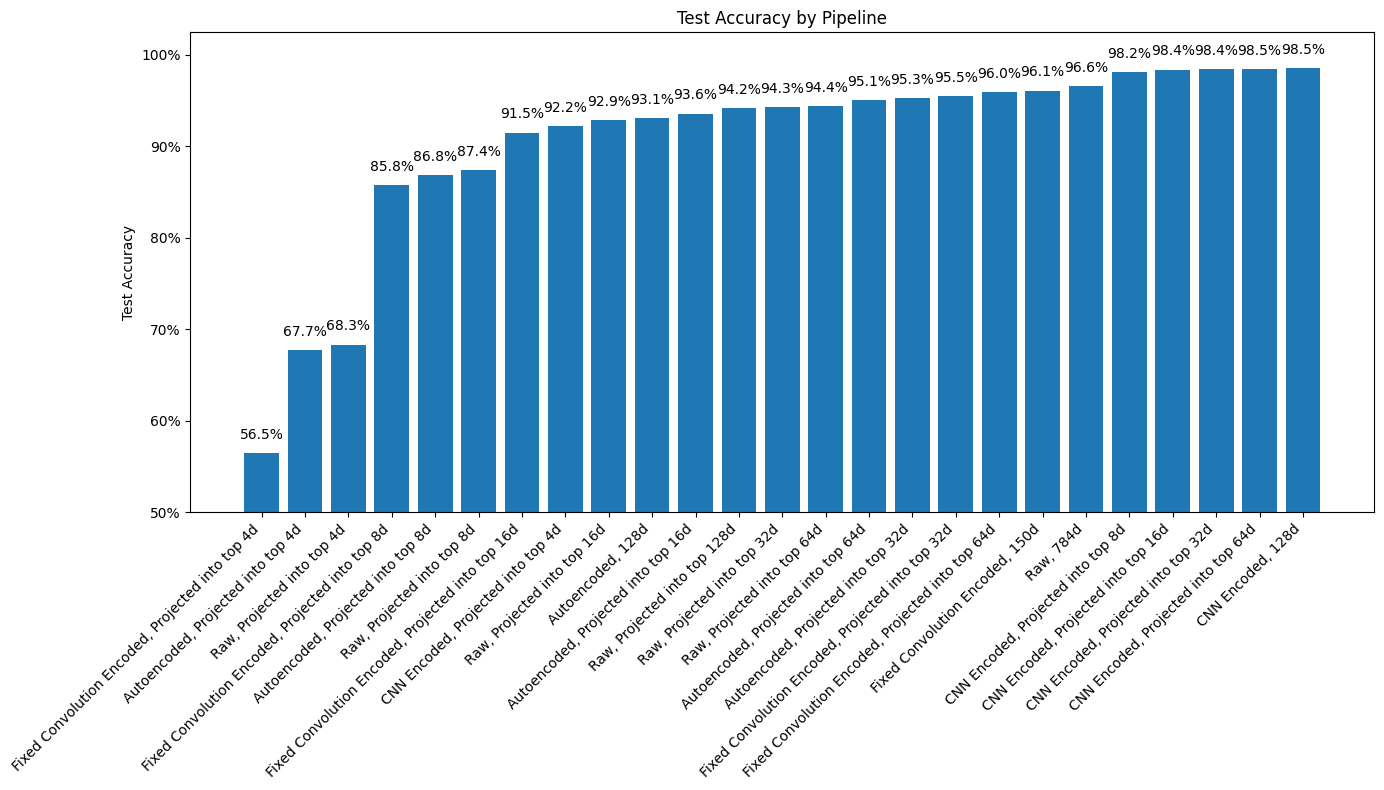

In [12]:
import matplotlib.ticker as mtick

# sort and unpack
sorted_results = sorted(results, key=lambda r: r[2])
names, train_accs, test_accs = zip(*sorted_results)

x = range(len(names))
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(x, test_accs)
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha="right")
ax.set_ylabel("Test Accuracy")
ax.set_title("Test Accuracy by Pipeline")
top = max(test_accs) * 1.04
ax.set_ylim(0.50, top)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# annotate bars
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + (top - 1.0) / 2,
        f"{h:.1%}",
        ha="center",
        va="bottom",
        clip_on=False
    )

plt.tight_layout()
plt.show()

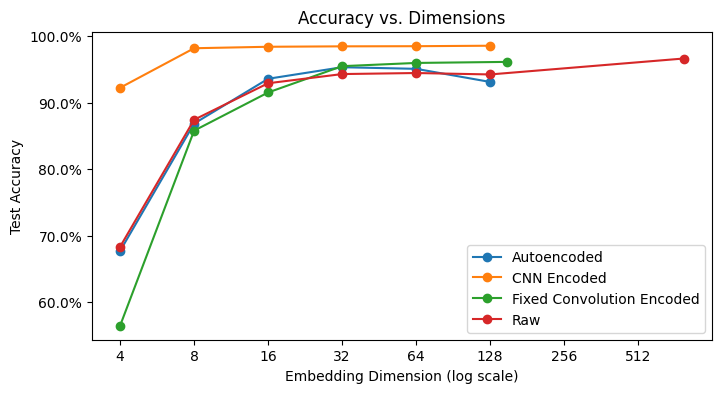

In [13]:
import matplotlib.ticker as mtick

df = pd.DataFrame(results, columns=["pipeline", "train", "test"])
df = df.sort_values("test").reset_index(drop=True)
pca_df = df[df["pipeline"].str.contains("Projected into top")].copy()
pca_df["method"] = pca_df["pipeline"].str.replace(r", Projected into top.*", "", regex=True)
pca_df["dim"]    = pca_df["pipeline"].str.extract(r"top (\d+)d").astype(int)

# append the pre‑PCA point for each method
extras = [
    ("Raw, 784d",                       "Raw",                         784),
    ("CNN Encoded, 128d",               "CNN Encoded",                 128),
    ("Fixed Convolution Encoded, 150d", "Fixed Convolution Encoded",   150),
    ("Autoencoded, 128d",               "Autoencoded",                 128),
]
for name, method, dim in extras:
    row = df[df["pipeline"] == name]
    if not row.empty:
        pca_df = pd.concat([pca_df, pd.DataFrame({
            "pipeline": [name],
            "train":    [row["train"].iloc[0]],
            "test":     [row["test"].iloc[0]],
            "method":   [method],
            "dim":      [dim]
        })], ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 4))
for method, group in pca_df.groupby("method"):
    grp = group.sort_values("dim")
    ax.plot(grp["dim"], grp["test"], marker="o", label=method)
ax.set_xscale('log', base=2)
ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.set_xlabel("Embedding Dimension (log scale)")
ax.set_ylabel("Test Accuracy")
ax.set_title("Accuracy vs. Dimensions")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend()
plt.show()

### Image Extraction for Report

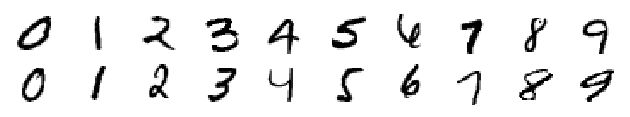

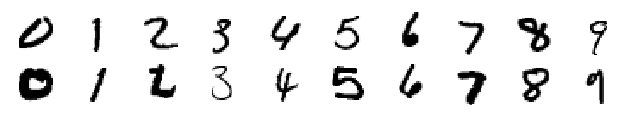

In [14]:
def pick_samples(X, y, shape=(2, 10)):
    n_rows, n_classes = shape
    samples = np.zeros((n_rows, n_classes, 28, 28), dtype=X.dtype)
    seen = {c: 0 for c in range(n_classes)}
    N = X.shape[0]
    for idx in range(N):
        cls = int(y[idx])
        if seen[cls] < n_rows:
            row = seen[cls]
            samples[row, cls] = X[idx].reshape(28,28)
            seen[cls] += 1
            if all(v == n_rows for v in seen.values()):
                break
    return samples

def plot_grid(samples, shape):
    n_rows, n_classes = shape
    fig, axes = plt.subplots(n_rows, n_classes)
    for r in range(n_rows):
        for c in range(n_classes):
            ax = axes[r, c]
            ax.imshow(samples[r, c], cmap='gray_r', interpolation='nearest')
            ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.50])
    plt.show()

train_shape = (2, 10)
train_samples = pick_samples(X, y, train_shape)
test_shape = (2, 10)
test_samples = pick_samples(X_test,  y_test, test_shape)
plot_grid(train_samples, train_shape)
plot_grid(test_samples, test_shape)
